In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data=pd.read_excel("C:\ML&AI\TextClassification\RAW DATA(Main Update)#2 (2019-07-02).xlsx", sheet_name="All",skiprows=5)
data.columns.tolist()

#countries_english=['RLTD','RAME','RIND','RPAC','RSAF','RKOR']



['ANALYZER_TYPE',
 'Work Type',
 'Business Unit (Owning User)',
 'Serial Number (Related Installation)',
 'Related Account',
 'Location (Related Installation)',
 'Installation Date (Related Installation)',
 'Departure Time',
 'Modified On',
 'Case Type (Related Case)',
 'Primary Fault Lvl1',
 'Primary Fault Part',
 'Related Case',
 'Case Description',
 'Investigation',
 'Corrective Action',
 'Primary Fault Corrective Action (Related Case)',
 'Error Code (Related Case)',
 'QC passed',
 'Owner',
 'SWO Number',
 'Case Number (Related Case)',
 'Filtering\n(Credit/Age/Class)',
 'Analyzer Group',
 'Primary Fault Code',
 'Primary Fault Code No',
 'Part Group Level2',
 'Missing Code',
 'Age(days)',
 'DHR month(Done_Date)',
 'Done_Date_Calc',
 'Create_Date_calc',
 'Sales_month(DHR)',
 'DHR Month(Create Date)',
 'Days between Sold_data and upSWO',
 'First Visit\n(Done_month)',
 'Days between sold and first upSWO (X)',
 'Count if witin 30 days',
 'Days since last upSWO',
 'CountIf UpSWO',
 'Credi

In [3]:
filtered_data = data[(data["Filtering\n(Credit/Age/Class)"]=="No") & (data["Work Type"]=="Visit") & (data["Case Type (Related Case)"]=="Complaint") & (data["Country"].str.contains("RLTD|RAME|RIND|RPAC|RSAF|RKOR"))]
                 
filtered_data.drop_duplicates(subset="SWO Number")

#reset all indexes as we dropped rows above
filtered_data = filtered_data.reset_index(drop=True)

#concatenate 3 columns of text
filtered_data['Text']= filtered_data['Case Description'] +' ' + filtered_data['Investigation'] + ' ' + filtered_data['Corrective Action']

# final columns for classification
dataframe=filtered_data.loc[:,['SWO Number','Text','RMED FaultCode L1(New)']]
#,'RMED FaultCode L2(New)', 'RMED FaultCode L3(New)', 'RMED FaultCode L4(New)',]

#If the count of target is less than 5%, combine to others type
classif = dataframe['RMED FaultCode L1(New)'].value_counts(normalize=True)
idx = classif[classif.lt(0.05)].index
dataframe.loc[dataframe['RMED FaultCode L1(New)'].isin(idx),'RMED FaultCode L1(New)'] = 'Others'

#prediction data -  save the rows where tgt is blank from dataframe
pred_X_Y = dataframe.loc[dataframe['RMED FaultCode L1(New)'].isnull(), ['SWO Number','Text','RMED FaultCode L1(New)']]

#get data after filtering where target is blank and text is blank
dataframe = dataframe.loc[dataframe['RMED FaultCode L1(New)'].notnull(), ['SWO Number','Text','RMED FaultCode L1(New)']]
dataframe = dataframe.loc[dataframe['Text'].notnull(), ['SWO Number','Text','RMED FaultCode L1(New)']]
dataframe = dataframe.reset_index(drop=True)

dataframe['RMED FaultCode L1(New)'].value_counts()

Defect                  993
Others                  320
Cleaned                 309
Assisted Replacement    270
Revisit required        192
Adjustment              162
Name: RMED FaultCode L1(New), dtype: int64

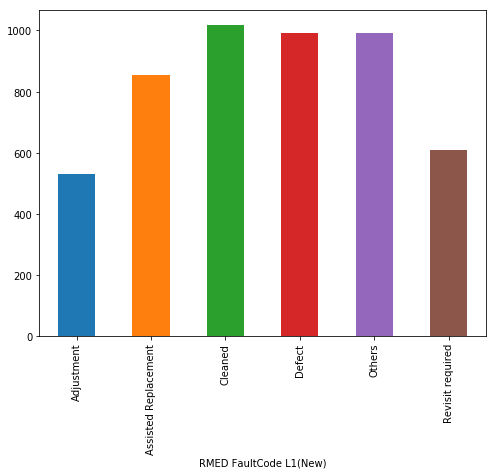

In [5]:
from sklearn.utils import resample
df_minority = dataframe[dataframe['RMED FaultCode L1(New)']!='Defect']
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=4000,     # to match minority class
                                 random_state=123) # reproducible results
df_minority_upsampled['RMED FaultCode L1(New)'].value_counts()

dataframe = dataframe[dataframe['RMED FaultCode L1(New)']=='Defect']
dataframe = pd.concat([dataframe,df_minority_upsampled])

dataframe['RMED FaultCode L1(New)'].value_counts()

#below is the check the imbalance classes
fig = plt.figure(figsize=(8,6))
dataframe.groupby('RMED FaultCode L1(New)').Text.count().plot.bar(ylim=0)
plt.show()

In [6]:
dataframe['category_id'] = dataframe['RMED FaultCode L1(New)'].factorize()[0]
category_id_dataframe = dataframe[['RMED FaultCode L1(New)', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_dataframe.values)
id_to_category = dict(category_id_dataframe[['category_id', 'RMED FaultCode L1(New)']].values)
dataframe.head()

,SWO Number,Text,RMED FaultCode L1(New),category_id
0,SWO-157241,"Agnes Lyczek, Emergency Dept. St Helier Hospit...",Defect,0
1,SWO-157489,Leak detected Leakage from tubing near oxi val...,Defect,0
3,SWO-157452,Natalie Vaughan Tel 0208 8695402 The customer ...,Defect,0
12,SWO-159862,Customer complaint that no print is coming aft...,Defect,0
13,SWO-159936,"Known psu issues wont switch to battery, repla...",Defect,0


In [7]:
import re
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
#min_df = When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
#norm='l2' = The cosine similarity between two vectors is their dot product when l2 norm has been applied.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2),
                        stop_words='english',token_pattern=r'(?u)\b[A-Za-z]+\b', tokenizer=stemming_tokenizer)
features = tfidf.fit_transform(dataframe.Text).toarray()
labels = dataframe.category_id
features.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop

(4993, 25289)

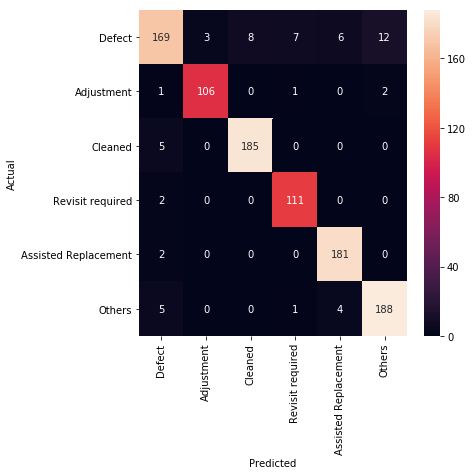

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import seaborn as sns

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, dataframe.index, test_size=0.20, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=category_id_dataframe['RMED FaultCode L1(New)'].values, yticklabels=category_id_dataframe['RMED FaultCode L1(New)'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [37]:
from IPython.display import display
for predicted in category_id_dataframe.category_id:
  for actual in category_id_dataframe.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 5:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(dataframe.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['SWO Number', 'Text']])
      print('')

'Cleaned' predicted as 'Defect' : 5 examples.


,SWO Number,Text
1407,SWO-431294,Haval Ozgun 07737 457222 Analyser found to be ...
2116,SWO-552724,Keeps asking to change SP and SC\nSidki AKay K...
1786,SWO-508909,Rinse error. Check the system. Clean the rinse...
508,SWO-285745,Oximetry parameters are failed in calibration....
508,SWO-285745,Oximetry parameters are failed in calibration....
508,SWO-285745,Oximetry parameters are failed in calibration....
508,SWO-285745,Oximetry parameters are failed in calibration....



'Others' predicted as 'Defect' : 5 examples.


,SWO Number,Text
180,SWO-203484,Simon Donnelly Tel 0203 2994446 Bleep 411 Anal...
746,SWO-321506,Customer states that the inlet intermittently ...
1030,SWO-374469,Hypochlorite Detected in analyzer. Unit givin...
1030,SWO-374469,Hypochlorite Detected in analyzer. Unit givin...
1030,SWO-374469,Hypochlorite Detected in analyzer. Unit givin...
1030,SWO-374469,Hypochlorite Detected in analyzer. Unit givin...
1030,SWO-374469,Hypochlorite Detected in analyzer. Unit givin...
1030,SWO-374469,Hypochlorite Detected in analyzer. Unit givin...
1030,SWO-374469,Hypochlorite Detected in analyzer. Unit givin...
1030,SWO-374469,Hypochlorite Detected in analyzer. Unit givin...



'Defect' predicted as 'Cleaned' : 8 examples.


,SWO Number,Text
348,SWO-261378,Process wheel error. Process wheel error. Chec...
2053,SWO-543292,"pressure test error, Oxi value error gasket ho..."
723,SWO-320222,Storage wheel is failed Remove broken catridge...
79,SWO-174399,Sample aborting again and again. Sample aborti...
1679,SWO-486870,Crea Failing QC QC Level 1 and 2 are failing f...
854,SWO-341057,Leakage in Gaskets Gasket Leakage Chekced the ...
1190,SWO-401675,Calibration failed after cal adjustment starte...
2225,SWO-571165,Temperature error in sample result Find temper...



'Defect' predicted as 'Revisit required' : 7 examples.


,SWO Number,Text
1288,SWO-412778,"Intermittent, frequent error 791, no Oximetry ..."
2067,SWO-545367,HCT measurements errors on patient samples Re...
523,SWO-289084,Oxi Parameters Failing on Level 3 of VK Kit Re...
2160,SWO-558197,Printing Problem Checked and found that when p...
2229,SWO-571968,Service Call. The analyzer is not switching on...
154,SWO-192555,Analyzer not Initializing it is showing error ...
1506,SWO-451336,Please call Anna 07984 464577 Screen frozen sa...



'Defect' predicted as 'Assisted Replacement' : 6 examples.


,SWO Number,Text
1181,SWO-400841,Ca failing calibrations \nStatus high 21.19 C...
289,SWO-242003,TREND FOR PCO2 FOUR LAST SEVERAL MONTHS HAS BE...
1082,SWO-386488,Customer states unit having Intermittent Inhom...
449,SWO-275866,Leakage at elmetII module. Leakage at Met2 mo...
461,SWO-278580,"Leak detected, unable to clear issue Client ad..."
2021,SWO-539722,"Error codes 1258, 1259, and 1264. Error codes ..."



'Defect' predicted as 'Others' : 12 examples.


,SWO Number,Text
1070,SWO-391078,Haval Ozgon Tel: 07737 457222 All three Analys...
784,SWO-326884,Unable to Edit patient demo graphics Customer ...
960,SWO-355308,Analyzer does not read the smart chip on the s...
776,SWO-326188,Unable to scan barcodes Continued investigatio...
1169,SWO-399228,Anna Morton 01708435000 ext 6672 or ext 2621 T...
1004,SWO-365926,Customer call stating analyzer will not automa...
84,SWO-175937,Lisa 01865 221596 customer reporting that the ...
1161,SWO-401389,Application software error. found application ...
1923,SWO-527416,Investigation by biomed Jakeer:\nAnlayser was ...
1284,SWO-412559,Claire Bailey Tel: 01708 435000 Analyser front...


In [25]:
model.fit(features, labels)
N = 10
for dataframe['RMED FaultCode L1(New)'], category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
#  print("# '{}':".format(dataframe['RMED FaultCode L1(New)']))
  print(category_id)
  print(category_to_id)
  print("  . Top unigrams:\n      . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))


1
{'Defect': 0, 'Adjustment': 1, 'Cleaned': 2, 'Revisit required': 3, 'Assisted Replacement': 4, 'Others': 5}
  . Top unigrams:
      . lamp
       . adjust
       . close
       . reset
       . halogen
       . misalign
       . jumper
       . rais
       . icon
       . cthb
  . Top bigrams:
       . inlet wheel
       . blank cal
       . posit adjust
       . halogen lamp
       . printer error
       . probe posit
       . reset jumper
       . stick probe
       . clean cabl
       . cabl reconnect
4
{'Defect': 0, 'Adjustment': 1, 'Cleaned': 2, 'Revisit required': 3, 'Assisted Replacement': 4, 'Others': 5}
  . Top unigrams:
      . membran
       . sp
       . electrod
       . replac
       . cassett
       . sensit
       . 964
       . cl
       . calibr
       . unstabl
  . Top bigrams:
       . replac solut
       . expir check
       . replac lactat
       . sensor cassett
       . qc fail
       . reagent calibr
       . membran run
       . electrod calibr
       . erro

In [16]:
from sklearn import metrics
#print(metrics.classification_report(y_test, y_pred, target_names=dataframe['RMED FaultCode L1(New)'].unique()))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
acc2=metrics.accuracy_score(y_test,y_pred)
print(acc2)

0.9409409409409409


In [ ]:
print(list(dataframe[dataframe['SWO Number']=='SWO-431294']['Text']))